In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *

In [8]:
df = pd.read_csv(vcf_path+"/shuffled.csv")
df.drop(columns='patient_id',inplace=True)  

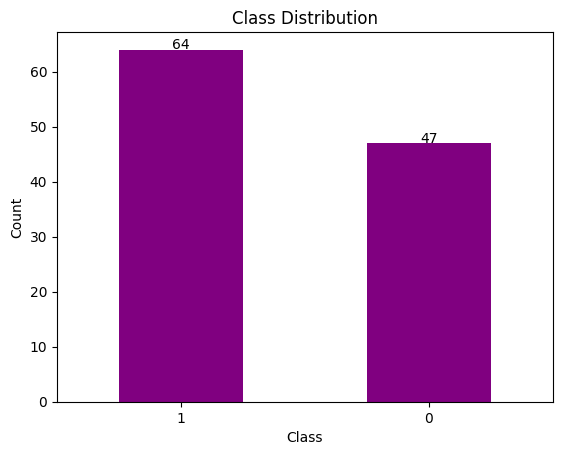

In [4]:
class_counts = df['label'].value_counts()
ax = class_counts.plot(kind='bar', color='purple', rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, count in enumerate(class_counts):
    ax.text(i, count + 0.1, str(count), ha='center')
plt.show()

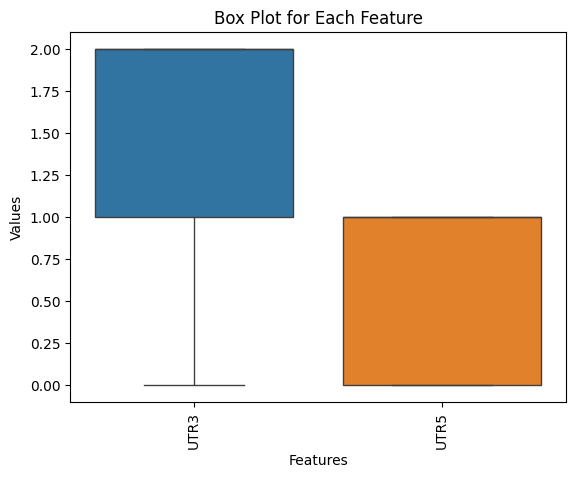

In [5]:
features = df.columns[1:-1]
sns.boxplot(data=df[features])
# Add title and labels
plt.title('Box Plot for Each Feature')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=90)
# Show the plot
plt.show()

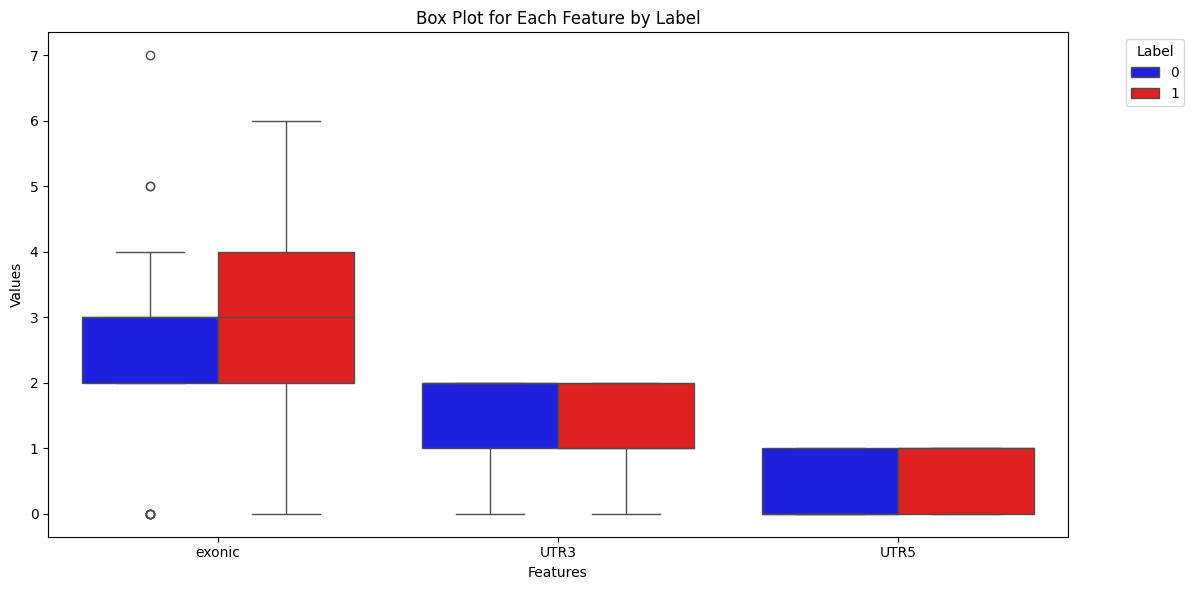

In [9]:
df_melted = df.melt(id_vars='label', var_name='Feature', value_name='Value')
palette = {0: 'blue', 1: 'red'}
plt.figure(figsize=(12, 6))  # Adjust figure size here
sns.boxplot(x='Feature', y='Value', hue='label', data=df_melted, palette=palette)
plt.title('Box Plot for Each Feature by Label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

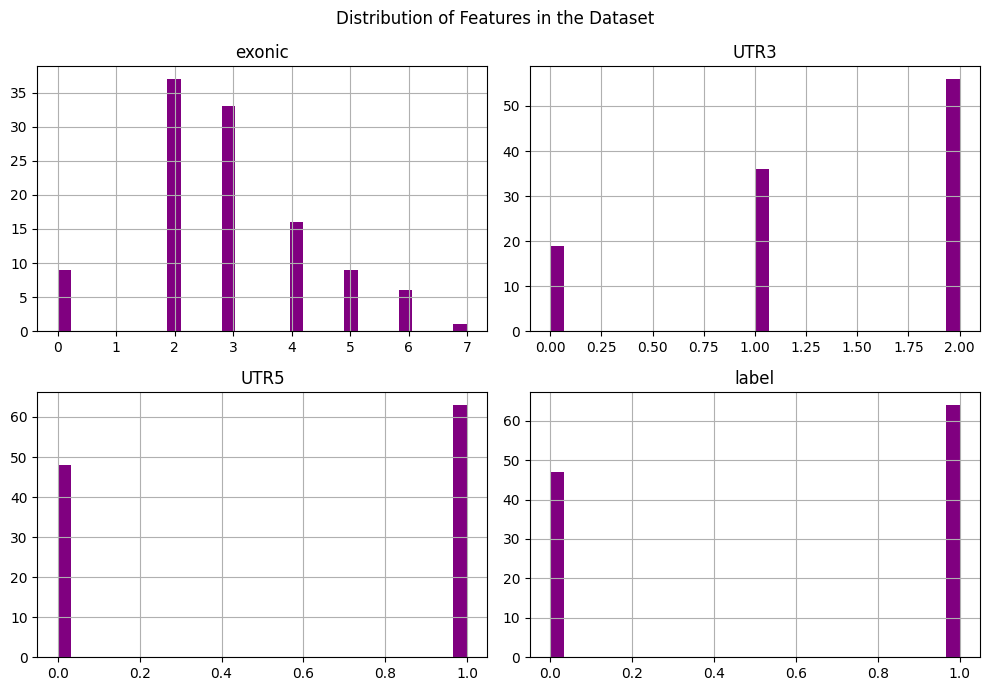

In [10]:
df.hist(bins=30,figsize=(10, 7), color='purple')
plt.suptitle("Distribution of Features in the Dataset")
plt.tight_layout()
plt.show()

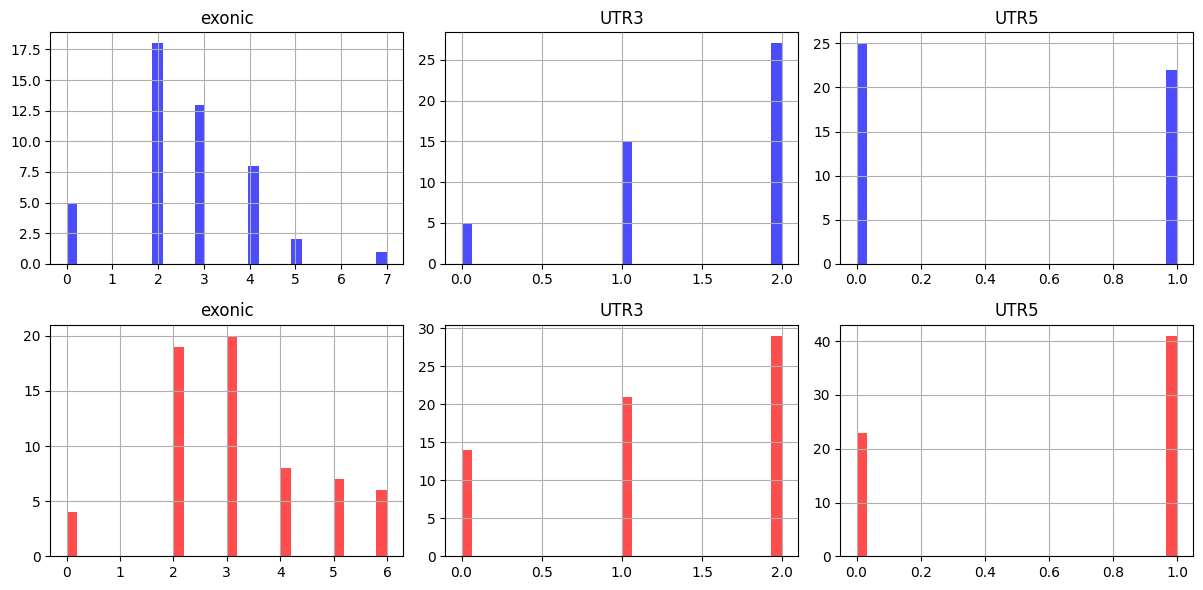

In [21]:
# Filter the DataFrame for label == 0 and label == 1
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot histogram for label 0
df_label_0.drop('label', axis=1).hist(bins=30, color='blue', alpha=0.7, ax=axes[0])
# Plot histogram for label 1
df_label_1.drop('label', axis=1).hist(bins=30, color='red', alpha=0.7, ax=axes[1])
# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
outliers = {}
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
print("Outliers detected:")
for feature, outlier_values in outliers.items():
    if not outlier_values.empty:
        print(f"{feature}: {outlier_values.tolist()}")

Outliers detected:


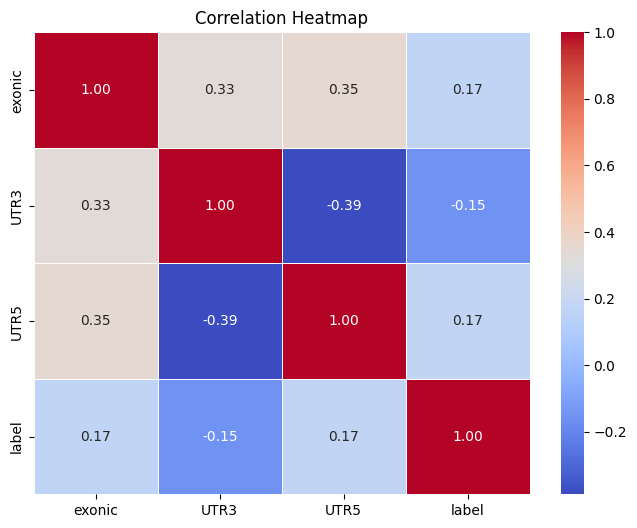

In [23]:
corr = df.corr()
plt.figure(figsize=(8, 6))  # Optional: Adjust the size of the figure
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
import umap 

/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


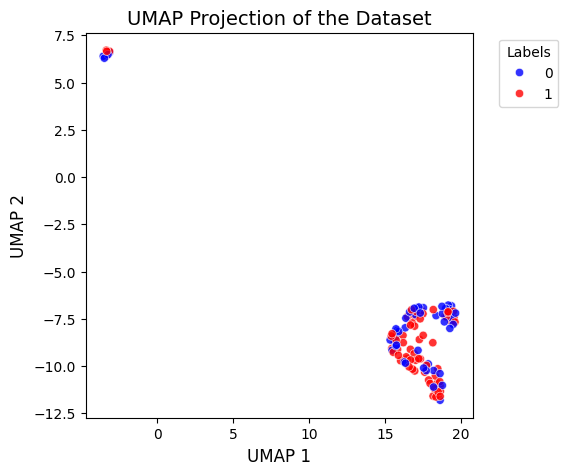

In [25]:
label = df['label']
reducer = umap.UMAP(metric='euclidean')
embedding = reducer.fit_transform(df.drop(columns=['label']))  # Drop the label column before fitting
plt.figure(figsize=(5, 5))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, palette=palette, alpha=0.8)
plt.title('UMAP Projection of the Dataset', fontsize=14)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


splitting

In [27]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['label'])  # Features (independent variables)
y = df['label']  # Target variable (dependent variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 3), Testing set size: (23, 3)


logistic regression

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

Check the Range of Each Feature: Are the counts across different features similar in magnitude? For example, if you have features like counts of mutations in different genes, check if their ranges overlap or if some counts are much higher than others.

Check Model Type:

If using gradient descent-based models (e.g., logistic regression, neural networks), scaling might be important even for count features, especially if the ranges are very different.
If using tree-based models (e.g., decision trees, random forests), scaling is generally not needed, as they are not affected by feature magnitudes.
Visual Inspection: Plot histograms of your features to see how spread out the counts are. If the distributions are skewed or have very different ranges, scaling can help.

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)  # Transform testing data

In [30]:
# Initialize and train logistic regression model
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)
# Make predictions
y_pred = logistic.predict(X_test)

Accuracy: 0.6087

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.60      0.92      0.73        13

    accuracy                           0.61        23
   macro avg       0.63      0.56      0.52        23
weighted avg       0.63      0.61      0.54        23



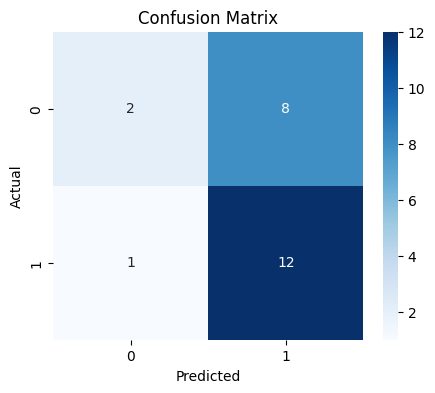

In [31]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


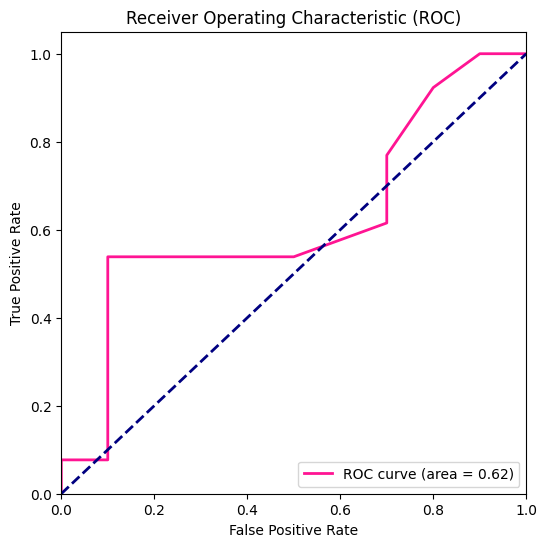

In [32]:
# Get probability scores for the positive class (label = 1)
y_probs =logistic.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

ensemble

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [34]:
# Initialize individual models
logreg = LogisticRegression()
svc = SVC(probability=True)  # Set probability=True for soft voting
dt = DecisionTreeClassifier()
ensemble_model = VotingClassifier(estimators=[('logreg', logreg), ('svc', svc), ('dt', dt)], voting='soft')
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

Accuracy: 0.5652

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.58      0.85      0.69        13

    accuracy                           0.57        23
   macro avg       0.54      0.52      0.49        23
weighted avg       0.54      0.57      0.51        23



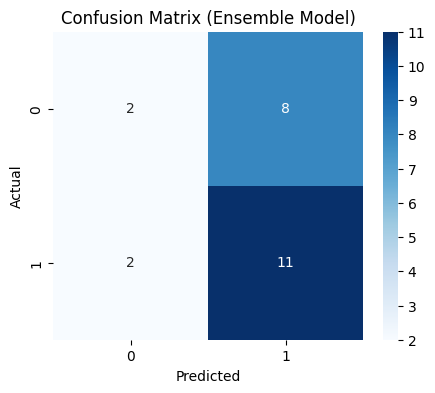

In [35]:
accuracy = accuracy_score(y_test, y_pred)  # Use y_pred from ensemble model
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)  # Use y_pred from ensemble model
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ensemble Model)")
plt.show()

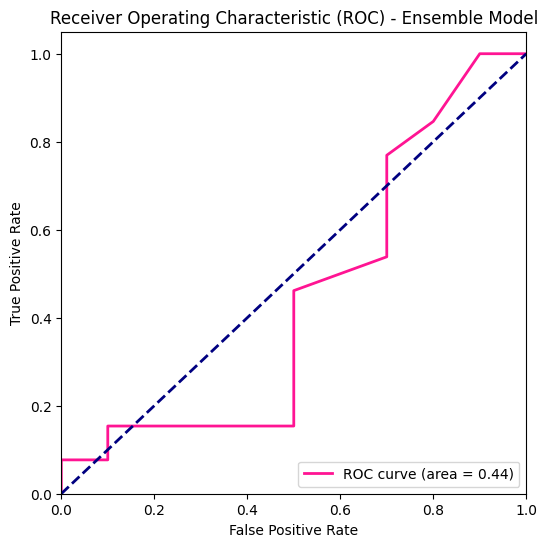

In [36]:
y_probs = ensemble_model.predict_proba(X_test)[:, 1]  # Use ensemble model's probabilities
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Ensemble Model')
plt.legend(loc='lower right')
plt.show()